## Import

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import mixed_precision

## Functions

In [30]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [29]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## Download the OxfordFlowers102 Dataset from TFDS

https://www.tensorflow.org/datasets/catalog/oxford_flowers102

In [2]:
(train_data, val_data, test_data), dataset_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True, # data gets returned in tuple format (data, label)
    shuffle_files=True,
)

In [3]:
class_names = dataset_info.features['label'].names
num_classes = len(class_names)
num_train = len(train_data)
num_validation = len(val_data)
num_test = len(test_data)

print('Classes:', class_names)
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_train))
print('Total Number of Validation Images: {}'.format(num_validation))
print('Total Number of Test Images: {}'.format(num_test))

Classes: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahl

In [14]:
for image, label in train_data.take(1):
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)
    print(f'Image: {image}\nLabel: {label}')


    Image shape: (500, 667, 3)
    Image datatype: <dtype: 'uint8'>
    Target class (tensor form): 72
    Class name (str form): water lily
    
Image: [[[1 2 0]
  [1 2 0]
  [1 2 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 2 0]
  [1 2 0]
  [1 2 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 2 0]
  [1 2 0]
  [1 2 0]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [6 7 2]
  [6 7 2]
  [5 6 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [6 7 2]
  [6 7 2]
  [5 6 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [6 7 2]
  [6 7 2]
  [5 6 1]]]
Label: 72


### Random review

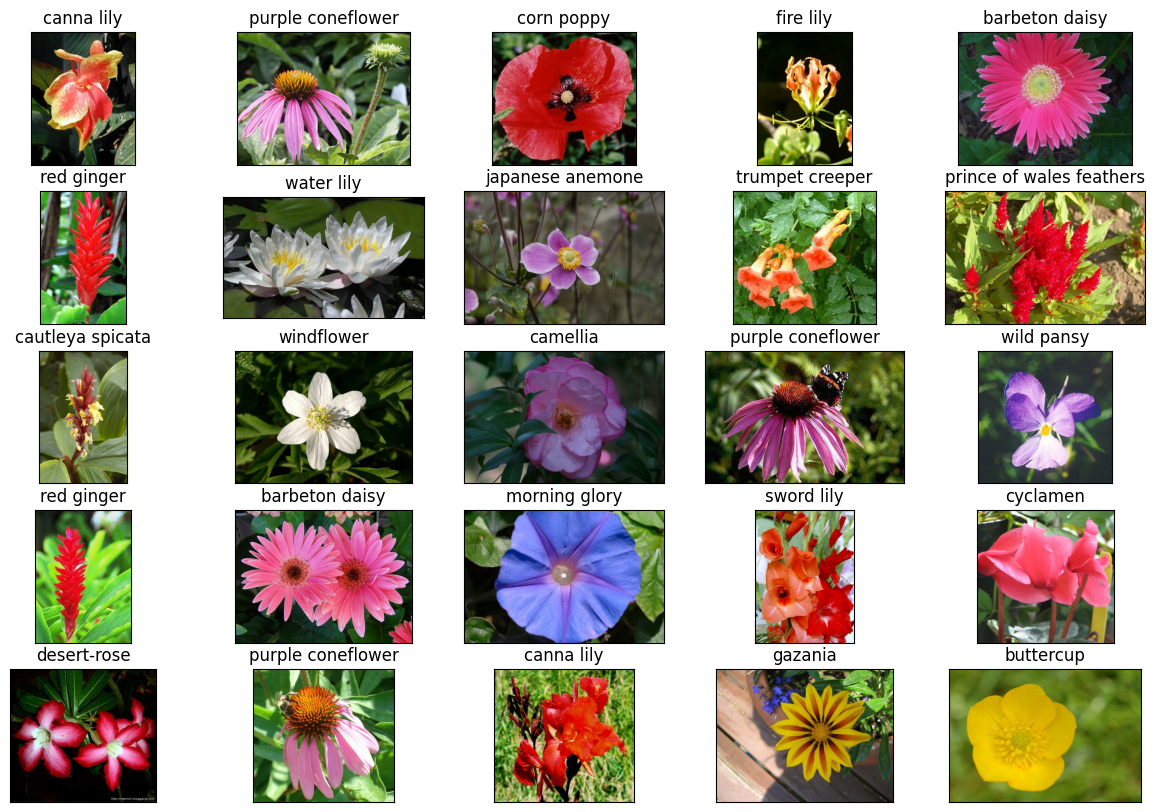

In [5]:
plt.figure(figsize=(15, 10))
i = 0
for i, (image, label) in enumerate(train_data.shuffle(100).take(25)):
    #image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
plt.show()

## Reformat images and Create batches

In [6]:
BATCH_SIZE = 32
IMG_SHAPE = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  # image /= 255. # not required for models like EfficientNetBX 
  return tf.cast(image, tf.float32), label

train_batches = train_data.map(map_func=format_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_batches = val_data.map(map_func=format_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_batches = test_data.map(map_func=format_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Build models using pretrained models on `tf.keras.applications`

### (Optional) Create a model checkpoint callback

In [34]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_checkpoint/cp.ckpt',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

### Turn on Mixed Precision training

https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types top speed up model performance.

In [9]:
# Turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [10]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### EfficientNetB0

In [35]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3), name='input_layer')

augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescaling(1./255), # needed by models like ResNet50V2 but EfficientNetB0
], name='augmentation_layers')

x = augmentation_layers(input_layer)

x = base_model(x, training=False)
print(f'Shape after passing inputs through base mode: {x.shape}')

# aggregate all the most important information, reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_2d_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

x = tf.keras.layers.Dense(len(class_names))(x)

output_layer = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

effnet_b0_model = tf.keras.Model(input_layer, output_layer)

effnet_b0_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

inital_epochs = 5

effnet_b0_history = effnet_b0_model.fit(
    train_batches,
    epochs=inital_epochs,
    validation_data=val_batches,
    callbacks=[model_checkpoint]
)

Shape after passing inputs through base mode: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Epoch 1/5


32/32 [==============================] - 47s 1s/step - loss: 4.3082 - accuracy: 0.1088 - val_loss: 3.5793 - val_accuracy: 0.3637
Epoch 2/5
32/32 [==============================] - 34s 1s/step - loss: 3.0053 - accuracy: 0.5755 - val_loss: 2.6961 - val_accuracy: 0.6039
Epoch 3/5
32/32 [==============================] - 33s 1s/step - loss: 2.1445 - accuracy: 0.7539 - val_loss: 2.1300 - val_accuracy: 0.6873
Epoch 4/5
32/32 [==============================] - 34s 1s/step - loss: 1.6306 - accuracy: 0.8382 - val_loss: 1.7612 - val_accuracy: 0.7343
Epoch 5/5
32/32 [==============================] - 33s 1s/step - loss: 1.2575 - accuracy: 0.8725 - val_loss: 1.5315 - val_accuracy: 0.7598


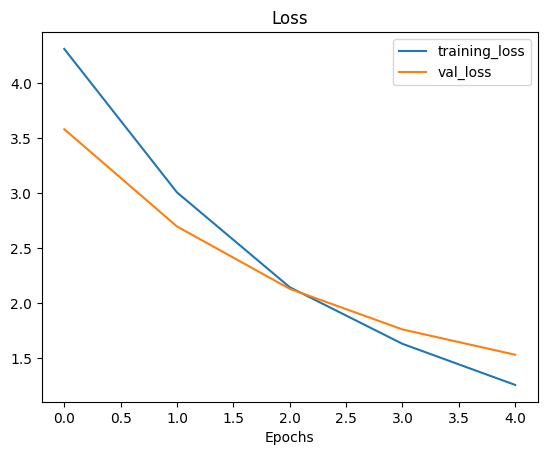

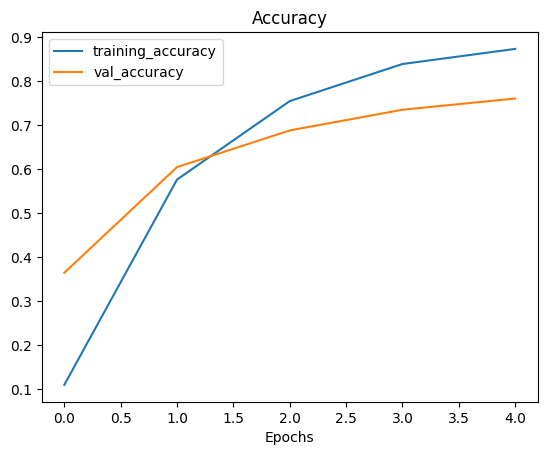

In [37]:
plot_loss_curves(effnet_b0_history)

### Fine-tuning model

In [38]:
for i, layer in enumerate(effnet_b0_model.layers):
    print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_layer True float32 <Policy "float32">
1 augmentation_layers True float32 <Policy "mixed_float16">
2 efficientnetb0 False float32 <Policy "mixed_float16">
3 global_average_pooling_2d_layer True float32 <Policy "mixed_float16">
4 dense_2 True float32 <Policy "mixed_float16">
5 output_layer True float32 <Policy "float32">


#### Unfreeze the top 10 layers

In [39]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [40]:
effnet_b0_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning typically want to lower the learning rate by 10X
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

finetune_epochs = inital_epochs + 5

effnet_b0_finetune_history = effnet_b0_model.fit(
    train_batches,
    epochs=finetune_epochs,
    validation_data=val_batches,
    initial_epoch=effnet_b0_history.epoch[-1] # start training from previous last epoch
)

Epoch 5/10


32/32 [==============================] - 51s 1s/step - loss: 0.7550 - accuracy: 0.9069 - val_loss: 1.0841 - val_accuracy: 0.7588
Epoch 6/10
32/32 [==============================] - 33s 1s/step - loss: 0.4503 - accuracy: 0.9363 - val_loss: 0.9310 - val_accuracy: 0.7824
Epoch 7/10
32/32 [==============================] - 33s 1s/step - loss: 0.3445 - accuracy: 0.9451 - val_loss: 0.8474 - val_accuracy: 0.7971
Epoch 8/10
32/32 [==============================] - 33s 1s/step - loss: 0.2845 - accuracy: 0.9490 - val_loss: 0.8040 - val_accuracy: 0.7971
Epoch 9/10
32/32 [==============================] - 33s 1s/step - loss: 0.2108 - accuracy: 0.9676 - val_loss: 0.7843 - val_accuracy: 0.8020
Epoch 10/10
32/32 [==============================] - 33s 1s/step - loss: 0.1724 - accuracy: 0.9775 - val_loss: 0.7270 - val_accuracy: 0.8118


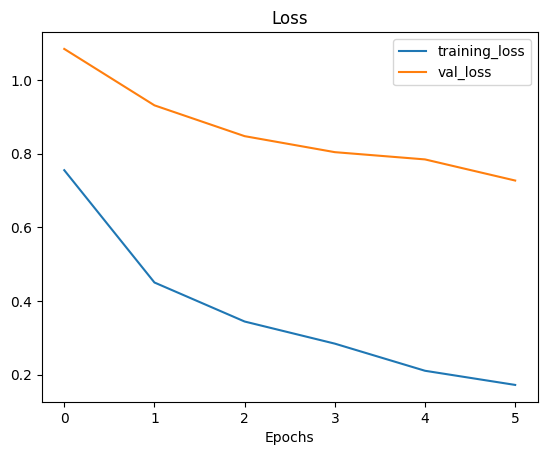

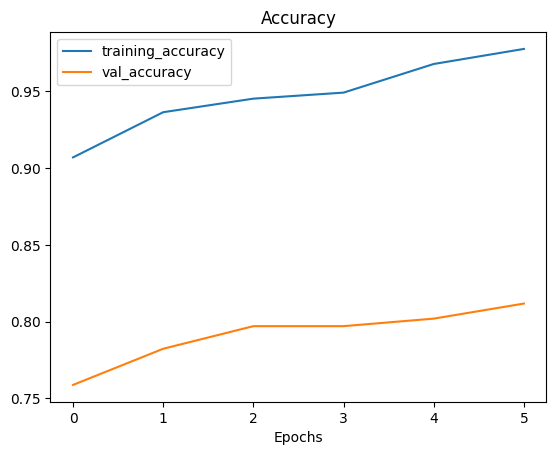

In [41]:
plot_loss_curves(effnet_b0_finetune_history)

### Before & After fine-tuning

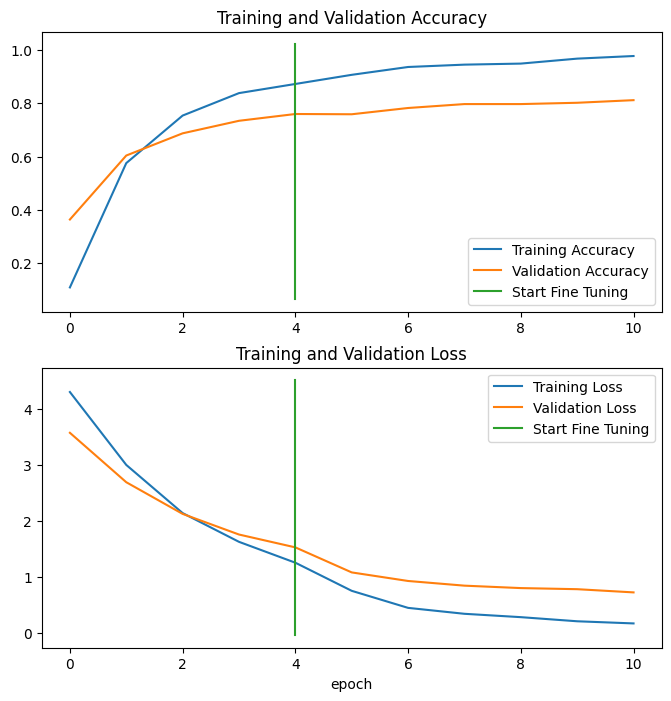

In [42]:
compare_historys(effnet_b0_history, effnet_b0_finetune_history, inital_epochs)

## Evalute the model

In [47]:
eval = effnet_b0_model.evaluate(test_batches, verbose=1)

for name, value in zip(effnet_b0_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

193/193 [==============================] - 35s 181ms/step - loss: 0.7771 - accuracy: 0.7923
loss: 0.7771181464
accuracy: 0.7923239470
